In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import photRM # credits Dr Anđelka Kovačević & Isidora Jankov (https://github.com/LSST-sersag/dle)
from rm_utils import ZDCF, load_results_ZDCF, PLIKE # functions to wrap fortran programs
%load_ext autoreload

## Making sure the fortran programs are compiled

In [126]:
FORTRAN_DIR = 'fortran_dir'
os.chdir(FORTRAN_DIR)
! gfortran zdcf_v2.2.f90 -o zdcf
! gfortran plike_v4.0.f90 -o plike
os.chdir('../')

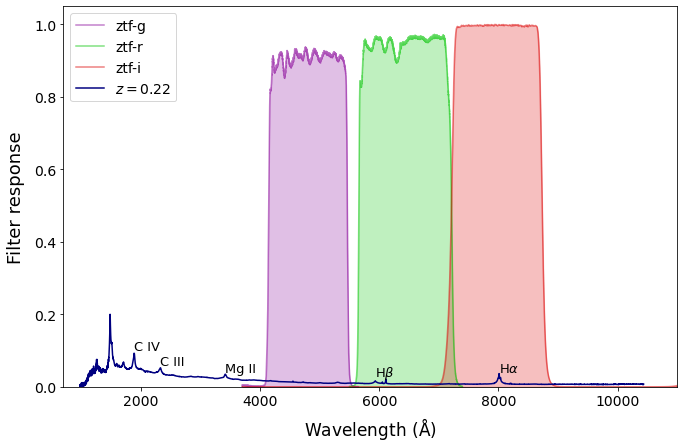

In [3]:
photRM.filters_viz(z=0.22, phot_sys='ZTF', save=True)


- **<font color='violet'> $g$-band covers continuum </font>**
- **<font color='#0AD304'>$r$-band covers Hb and continuum </font>**
- **<font color='indianred'> $i$-band covers Ha and continuum </font>**

We choose **g band** for pure continuum light curve (X-band) and **r band** for continuum + line light curve (Y-band).

**Note:** i-band light curves usually have much lower number of points compared to g and r bands, which is the reason for not considering it in this analysis.

#### Light curves we want to to RM on are tsv w/ columns as:
t, mag, magerr

In [113]:
ZDCF('x_band_sim', 'y_band_sim', 'acf1')
ZDCF('x_band_sim', 'y_band_sim', 'ccf1', ccf=True)

ZDCF V2.2 begins:
Auto-correlation or cross-correlation? (1/2):
Enter output files prefix:
Uniform sampling of light curve? (y/n):
Enter minimal number of points per bin (0 for default):
Omit zero-lag points? (y/n):
How many Monte Carlo runs for error estimation?

ZDCF PARAMETERS:
Autocorrelation?  T
Uniform sampling? F
Omit zero lags?   T
Minimal # in bin:         11
# of Monte Carlo:        100
Monte Carlo seed:     123456
Enter name of 1st light curve file:

 acf1.lc1  written (contains         1000  points) ...
 acf1.lc2  written (contains         1000  points) ...

Binning with minimum of  11 points per bin and resolution of 1.00E-03 .

       990 bins actually used,         45 inter-dependent pairs discarded.

  tau       -sig(tau)  +sig(tau)   dcf        -err(dcf)  +err(dcf) (#bin)

  1.000E+00  0.000E+00  0.000E+00  9.664E-01  2.123E-03  2.059E-03 ( 999)
  2.000E+00  0.000E+00  0.000E+00  9.345E-01  4.075E-03  3.956E-03 ( 998)
  3.000E+00  0.000E+00  0.000E+00  9.041E-01  5.873

### ZDCF saves results as acf1.dcf

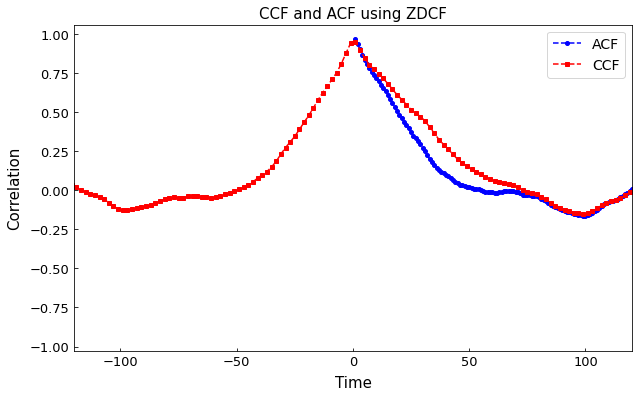

In [107]:
acf, ccf = load_results_ZDCF('acf1.dcf', 'ccf1.dcf', plot=True)

(1980, 7)
(992, 7)
(992, 7)
(992, 7)


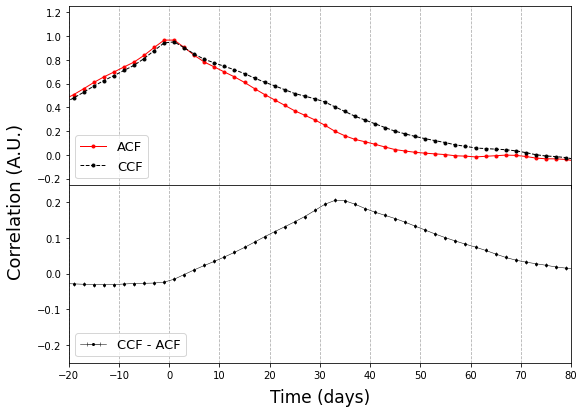

In [108]:
# since ZDCF does not provide the ACF on the negative tau axis, we need to add it:
acf_total = photRM.add_inverted_acf(acf)
print(acf_total.shape)
print(ccf.shape)
# We still need to make CCF and ACF the same length so we could subtract them.
# We do this by interpolating one of those functions to the time grid of the other.
acf_interp = photRM.interp(ccf, acf_total) # first param is the function having the x-axis on which we want to interpolate the other function.
print(acf_interp.shape)
print(ccf.shape)
# Subtracting CCF and ACF
final_ccf = photRM.delta_ccf(acf_interp, ccf)
final_ccf.to_csv('fortran_dir/plike_input_sim.dcf', sep=" ", index=False, header=False)
final_ccf.tail()
photRM.plot_ccf_acf(final_ccf, ccf, acf_interp, locator=10)

In [ ]:
PLIKE('plike_input_sim.dcf', 0,100) # will print results? make sure to sanity check the estimated lags

In [ ]:
# PLIKE results:
tau = 33
err_low = -2.66
err_high = 4.35
photRM.plot_ccf_acf(final_ccf, ccf, acf_interp, locator=10, peak=True, tau=tau, err_low=err_low, err_high=err_high, x1=-20, x2=80, y1=-0.5, y2=1)

